In [1]:
import os
import time
import datetime
import itertools
import cartopy
import matplotlib
import tqdm
import csv 
import geopandas as gpd
import rasterio as rio
import fiona
from mpl_toolkits.basemap import Basemap

import numpy as np
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import geopandas as gp
from sklearn.preprocessing import MinMaxScaler
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

import datetime as dt
from glob import glob
import xarray as xr
import rioxarray
from shapely.geometry import mapping

In [3]:
raster = rio.open('../code/OpenET_Ensemble_Tiffs/8985_ensemble_et_public_0.tif')
raster.crs

CRS.from_epsg(4326)

In [10]:
area_bs = gp.read_file("../shape/SGMA_Butte Subbasin_2018.shp")
area_bs_km2 = float(area_bs.to_crs(epsg=32611).area * 1e-6)
area_bs.to_crs(epsg=4326, inplace=True)

area_vs = gp.read_file("../shape/SGMA_Vina Subbasin_Bulletin 118-2018.shp")
area_vs_km2 = float(area_vs.to_crs(epsg=32611).area * 1e-6)
area_vs.to_crs(epsg=4326, inplace=True)

area_ws = gp.read_file("../shape/SGMA_Wyandotte Subbasin_2018.shp")
area_ws_km2 = float(area_ws.to_crs(epsg=32611).area * 1e-6)
area_ws.to_crs(epsg=4326, inplace=True)

In [4]:
out_image, out_transform = rio.mask.mask(raster, area_bs.geometry, crop=True)

In [5]:
raster_names = glob('../code/OpenET_Ensemble_Tiffs/*.tif')
butte_subbasin_openet = []
vina_subbasin_openet = []
wyandotte_subbasin_openet = []

In [6]:
for raster_name in raster_names:
    raster = rio.open(raster_name)
    out_image, out_transform = rio.mask.mask(raster, area_bs.geometry, crop=True)
    butte_subbasin_openet.append(out_image)
    out_image, out_transform = rio.mask.mask(raster, area_vs.geometry, crop=True)
    vina_subbasin_openet.append(out_image)
    out_image, out_transform = rio.mask.mask(raster, area_ws.geometry, crop=True)
    wyandotte_subbasin_openet.append(out_image)

In [7]:
butte_subbasin_open = np.vstack(butte_subbasin_openet)
vina_subbasin_open = np.vstack(vina_subbasin_openet)
wyandotte_subbasin_open = np.vstack(wyandotte_subbasin_openet)

In [11]:
butte_subbasin_open.shape

(79, 1991, 1460)

In [8]:
butte_sub_mean = np.nanmean(butte_subbasin_open, axis=(1,2))*1e-6*area_bs_km2
vina_sub_mean = np.nanmean(vina_subbasin_open, axis=(1,2))*1e-6*area_vs_km2
wyandotte_sub_mean = np.nanmean(wyandotte_subbasin_open, axis=(1,2))*1e-6*area_ws_km2

In [9]:
datetime_range = pd.date_range(start='2016-01', end='2022-08', freq='M')

In [10]:
print(len(butte_sub_mean))
print(len(datetime_range))

79
79


In [76]:
butte_df = pd.DataFrame(butte_sub_mean, index=datetime_range, columns = ['openet'])
vina_df = pd.DataFrame(vina_sub_mean, index=datetime_range, columns = ['openet'])
wyandotte_df = pd.DataFrame(wyandotte_sub_mean, index=datetime_range, columns = ['openet'])

In [77]:
butte_df.to_csv('../data/openet_butte_subbasin.csv')
vina_df.to_csv('../data/openet_vina_subbasin.csv')
wyandotte_df.to_csv('../data/openet_wyandotte_subbasin.csv')

In [4]:
xarray_image = xr.open_dataset('../code/OpenET_Ensemble_Tiffs/Butte_Basin_Open_ET_Earth_Engine.nc')

In [6]:
open_et_ee_median = xarray_image['et_ensemble_mad']
open_et_ee_max = xarray_image['et_ensemble_mad_max']
open_et_ee_min = xarray_image['et_ensemble_mad_min']

In [14]:
xarray_image.rio.write_crs(4326, inplace=True)
xarray_image.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
butte_subbasin_clipped = xarray_image.rio.clip(area_bs.geometry.apply(mapping), 
                                                area_bs.crs, drop=False)
vina_subbasin_clipped = xarray_image.rio.clip(area_vs.geometry.apply(mapping), 
                                                area_vs.crs, drop=False)
wyandotte_subbasin_clipped = xarray_image.rio.clip(area_ws.geometry.apply(mapping), 
                                                area_ws.crs, drop=False)

In [15]:
butte_subbasin_clipped = butte_subbasin_clipped*1e-6*area_bs_km2
vina_subbasin_clipped = vina_subbasin_clipped*1e-6*area_vs_km2
wyandotte_subbasin_clipped = wyandotte_subbasin_clipped*1e-6*area_ws_km2

In [17]:
butte_subbasin_timeseries = butte_subbasin_clipped.mean(['x','y'])
vina_subbasin_timeseries = vina_subbasin_clipped.mean(['x','y'])
wyandotte_subbasin_timeseries = wyandotte_subbasin_clipped.mean(['x','y'])

In [18]:
butte_subbasin_timeseries

<xarray.Dataset>
Dimensions:              (time: 66)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01 ... 2021-11-01
    spatial_ref          int64 0
Data variables:
    et_ensemble_mad      (time) float64 0.02461 0.05207 ... 0.04314 0.03027
    et_ensemble_mad_min  (time) float64 0.01595 0.03196 ... 0.03085 0.02047
    et_ensemble_mad_max  (time) float64 0.03348 0.07217 ... 0.05544 0.03991

In [20]:
butte_df = butte_subbasin_timeseries.to_dataframe()
vina_df = vina_subbasin_timeseries.to_dataframe()
wyandotte_df = wyandotte_subbasin_timeseries.to_dataframe()

In [21]:
butte_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66 entries, 2016-01-01 to 2021-11-01
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   spatial_ref          66 non-null     int64  
 1   et_ensemble_mad      66 non-null     float64
 2   et_ensemble_mad_min  66 non-null     float64
 3   et_ensemble_mad_max  66 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.6 KB


In [22]:
butte_df.to_csv('../data/openet_butte_subbasin_ee.csv')
vina_df.to_csv('../data/openet_vina_subbasin_ee.csv')
wyandotte_df.to_csv('../data/openet_wyandotte_subbasin_ee.csv')

In [5]:
sample = xr.open_dataset('../data/et_images/DisALEXI_Butte.nc')
sample

<xarray.Dataset>
Dimensions:      (time: 72, x: 174, y: 238)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2021-12-01
  * y            (y) float64 39.73 39.72 39.72 39.72 ... 39.2 39.2 39.2 39.19
  * x            (x) float64 -122.0 -122.0 -122.0 ... -121.6 -121.6 -121.6
    spatial_ref  (time) int64 ...
Data variables:
    DisALEXI_ET  (time, y, x) float64 ...
Attributes:
    transform:               [ 2.24578821e-03  0.00000000e+00 -1.24746798e+02...
    res:                     [0.00224579 0.00224579]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

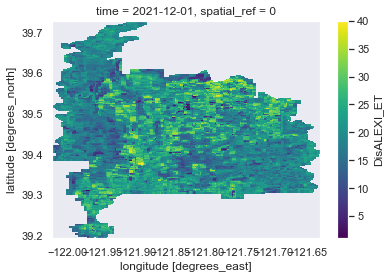

In [6]:
sample['DisALEXI_ET'].isel(time=-1).plot()